This notebook analyzes the trends of accidents in NYC in between 2012-2018 with an eventual goal of predicting the accidents involving injuries or deaths.

First, we will show some interesting dependencies of accidents by using the database acquired from https://opendata.cityofnewyork.us/, and then predict the accidents with fatalities (which involves injury or deaths) based on our preliminary analysis.

Let's load our dataset and start by visualizing the collision frequency as a function of the day of the year.

DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
[u'10/21/2018,0:00,BROOKLYN,11214,40.59039,-73.99155,26 AVENUE                       ,CROPSEY AVENUE,,0,0,0,0,0,0,0,0,Unspecified,,,,,4004212,Station Wagon/Sport Utility Vehicle,,,,']


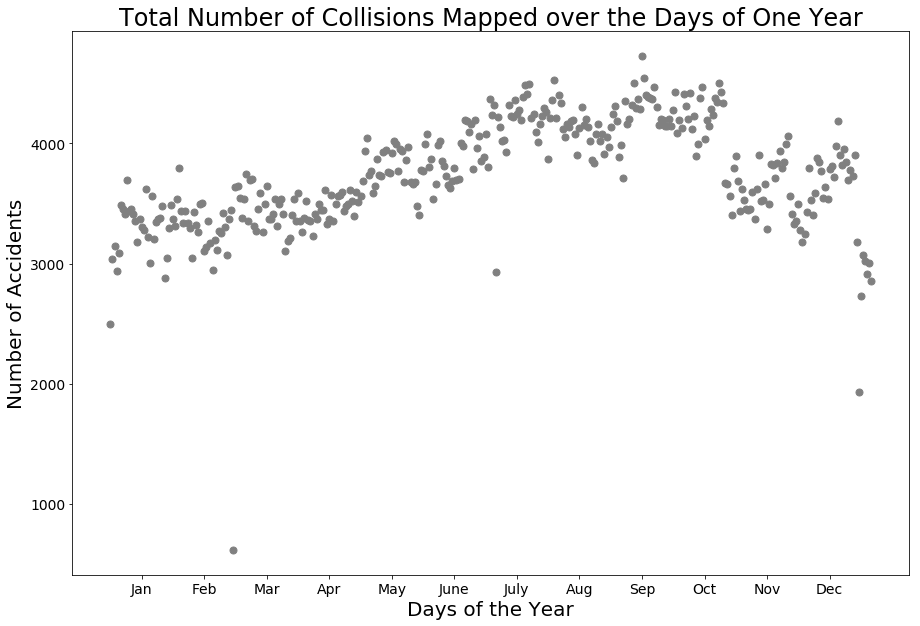

In [1]:
import findspark
findspark.init()

import datetime
import numpy as np
from pyspark import SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.classification import SVMWithSGD
import matplotlib.pyplot as plt
import seaborn as sns

#Let's start Spark and read our csv file
sc = SparkContext(appName = "traffic")
lines = sc.textFile("./NYPD_Motor_Vehicle_Collisions.csv")

#There are supposed to be 28 columns, so let's filter the other rows with fewer or more columns
lines = lines.filter(lambda x: len(x.split(',')) == 28)
header = lines.first()
lines = lines.filter(lambda x: x != header)
print header
print lines.take(1)

#Let's group the number of accidents by the day of the year
accidentPerDay = lines.map(lambda x: (x.split(',')[0][:-5].encode('utf8'),1))
totAccidentPerDay = accidentPerDay.reduceByKey(lambda x,y: x+y).collect()
dayoftheAccident, accidentCount = zip(*totAccidentPerDay)
dayoftheAccident, accidentCount = zip(*sorted(zip(dayoftheAccident, accidentCount)))

plt.figure(figsize=(15,10))
plt.plot(range(len(dayoftheAccident)), accidentCount,'.', markersize=14, linewidth=2, color='grey')

plt.xticks([15,45,75,105,135,165,195,225,255,285,315,345], ['Jan','Feb','Mar','Apr','May',
           'June','July','Aug','Sep','Oct','Nov','Dec'], fontsize=14)
plt.yticks(fontsize=14)
plt.title('Total Number of Collisions Mapped over the Days of One Year', fontsize = 24)
plt.ylabel('Number of Accidents', fontsize = 20)
plt.xlabel('Days of the Year', fontsize = 20)
plt.show()

Summer months are more prone to accidents with a peak around late August - early September. More interestingly, there are 4 days with significantly fewer accidents. The first one is January 1st; as it is a holiday and most of the stores are closed, people probably prefer to stay at home. Second one is February 29th (we have only one February 29 in our dataset, in 2016, whereas other days have a total accident count of an accumulation of 6 years). Third and fourth days with significantly fewer accidents are July 4th and December 25th, similarly, probably people prefer to spend time with family and stay at home these days.

Now, let's go into a little bit deeper and investigate the reasons of these accidents.

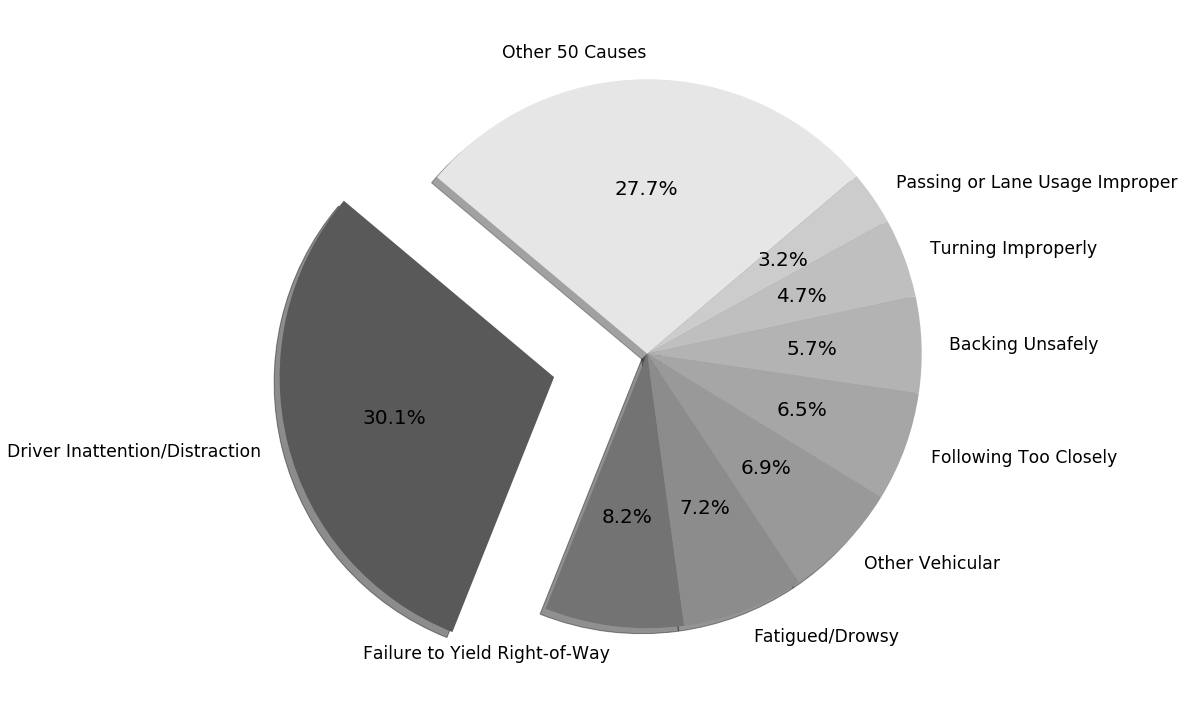

In [2]:
#Lets filter the rows with empty accident causes
lines = lines.filter(lambda x: len(x.split(',')[17]) > 0 and len(x.split(',')[18]) > 0)

def reasonMapper(lines, colNum):
    mapper = lines.map(lambda x: ((x.split(',')[0][-2:].encode('utf8'), x.split(',')[colNum].encode('utf8')),1))
    return mapper

reasonv1 = reasonMapper(lines, 17)
reasonv2 = reasonMapper(lines, 18)
reason = reasonv1.union(reasonv2)
totReason = reason.reduceByKey(lambda x,y: x+y).collect()

sortedByFrequencyOfReason = sorted(totReason, key=lambda x: x[1], reverse=True)
reasonOfAccidents, numberOfAccidents = zip(*sortedByFrequencyOfReason)

reasonDict = {}
for r in reasonOfAccidents:
    reasonDict[r[1]] = 0

for i in range(len(reasonOfAccidents)):
    reasonDict[reasonOfAccidents[i][1]] += numberOfAccidents[i]

reasons = reasonDict.keys()
numReasons = reasonDict.values()
fracReasons = [float(i)/sum(numReasons) for i in numReasons]
fracReasons, reasons = zip(*sorted(zip(fracReasons, reasons), reverse=True))

labels = list(reasons[:8]) + ['Other 50 Causes']
sizes = list(fracReasons[:8]) + [sum(fracReasons[8:])]

fig = plt.figure(figsize=(10,10))
colorspie = [[0.35,0.35,0.35], [0.45,0.45,0.45], [0.55,0.55,0.55], [0.6,0.6,0.6], 
          [0.65,0.65,0.65],[0.7,0.7,0.7], [0.75,0.75,0.75], [0.8,0.8,0.8],[0.9,0.9,0.9]]
explode = (0.35, 0, 0, 0, 0, 0, 0, 0, 0)

patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colorspie,
        autopct='%1.1f%%',textprops = {'fontsize':20}, shadow=True, startangle=140, radius = 1)

for t in texts:
    t.set_size('xx-large')    
plt.axis('equal')
plt.tight_layout()
plt.show()

The majority of the accidents happen due to driver inattention and distraction. It happens almost four times more frequent than the second most frequent cause (failure to yield right of way). The 'other 50 causes' portion of the pie stands for fifty other causes with frequencies 3% or less. 

Let's look at the variation of the number of accidents caused by driver inattention and distraction over the years.

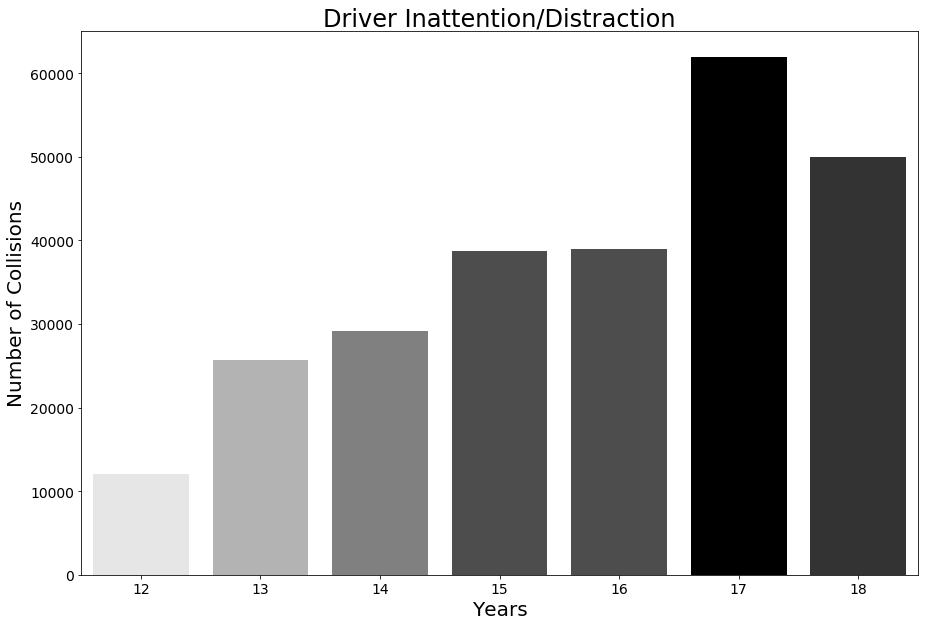

In [3]:
inattentionByYear = {}
for i in range(len(reasonOfAccidents)):
    if reasonOfAccidents[i][1] == 'Driver Inattention/Distraction':
        inattentionByYear[reasonOfAccidents[i][0]] = numberOfAccidents[i]

yearsInattention = inattentionByYear.keys()
totInattention = inattentionByYear.values()

fig = plt.figure(figsize=(15,10))
colorsbar = [[0.9,0.9,0.9],[0.7,0.7,0.7],[0.5,0.5,0.5],[0.3,0.3,0.3],[0.3,0.3,0.3],[0,0,0],[0.2,0.2, 0.2]]
ax2 = sns.barplot(yearsInattention, totInattention, palette=colorsbar)

plt.title('Driver Inattention/Distraction', fontsize = 24)
plt.xlabel("Years", fontsize = 20)
plt.ylabel("Number of Collisions", fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

We see an increasing trend in number of accidents over the last 7 years due to driver inattention and distraction (2018 column is incomplete as our dataset covers the accidents until October 2018). Indeed, there is more than 50% of a jump in numbers in between 2016 and 2017. We can speculate the involvement of social media in our lives generally distract people and there is an increasing number of accidents caused by driver inattention and distraction.

Now, let's start looking at the fatality trends. First, we will separately count the motorists, cyclists and pedestrians who get injured or died in the accidents.

In [4]:
# Let's group the motorists, cyclists and pedestarians get injured and dead
motoristFatalities = lines.map(lambda x: int(x.split(',')[16]) + int(x.split(',')[15]))
totmotoristFatalities = motoristFatalities.reduce(lambda x,y: x+y)

cyclistFatalities = lines.map(lambda x: int(x.split(',')[14]) + int(x.split(',')[13]))
totcyclistFatalities = cyclistFatalities.reduce(lambda x,y: x+y)

pedFatalities = lines.map(lambda x: int(x.split(',')[12]) + int(x.split(',')[11]))
totpedFatalities = pedFatalities.reduce(lambda x,y: x+y)

print 'Injuries and deaths involving a motorist:', totmotoristFatalities
print 'Injuries and deaths involving a cyclist:', totcyclistFatalities
print 'Injuries and deaths involving a pedestrian:', totpedFatalities

Injuries and deaths involving a motorist: 237047
Injuries and deaths involving a cyclist: 26491
Injuries and deaths involving a pedestarian: 3172


Now, let's try to identify the potentially important features to predict the fatalities in the accident data. To do this, we will use another dataset summarizing the weather information in NYC in between 2013-2018 from; https://www.wunderground.com. 

Date,AverageTemperature,AveragePrecipitation
[u'01/01/2013,34,0']


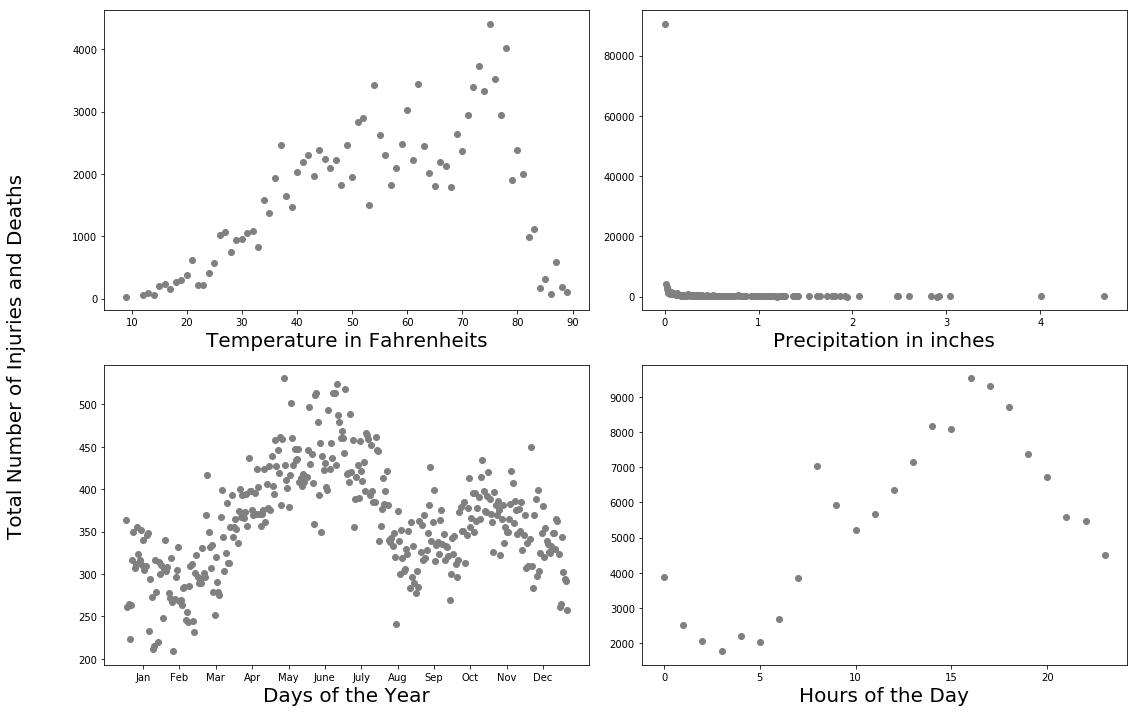

In [5]:
#We'll remove the rows with empty or wrong entries of lattitudes and longitudes from our data 
lines = lines.filter(lambda x: len(x.split(',')[4]) > 0 and len(x.split(',')[5]) > 0)
lines = lines.filter(lambda x: float(x.split(',')[4].encode('utf8')) > 35 and float(x.split(',')[4].encode('utf8')) < 45)
lines = lines.filter(lambda x: float(x.split(',')[5].encode('utf8')) > -80 and float(x.split(',')[5].encode('utf8')) < -70)
lines = lines.filter(lambda x: len(x.split(',')[3]) == 5)

def prepareAccidentData(x):
    date = x.split(',')[0]
    #I will consider the February 29th fatalities together with February 28 fatalities
    if x.split(',')[0][0:5] == '02/29':
        day = datetime.datetime.strptime('02/28','%m/%d').timetuple().tm_yday
    else:
        day = datetime.datetime.strptime(x.split(',')[0][0:5],'%m/%d').timetuple().tm_yday

    injuryAndDeath = int(x.split(',')[9]) + int(x.split(',')[10])
    
    if len(x.split(',')[1]) == 5:
        time = int(x.split(',')[1][0:2])
    else:
        time = int(x.split(',')[1][0])
        
    try: 
        zipCode = int(x.split(',')[3])
    except ValueError: 
        zipCode = 10000

    latitude = float(x.split(',')[4].encode('utf8'))
    longitude = float(x.split(',')[5].encode('utf8'))
        
    return (date,(injuryAndDeath,day,time,zipCode,longitude,latitude))

linesAcc = lines.map(prepareAccidentData)

#Let's combine the weather data and the traffic data together
linesW = sc.textFile('./weather.csv')
headerW = linesW.first()
linesW = linesW.filter(lambda x: x != headerW)
print headerW
print linesW.take(1)

linesW = linesW.map(lambda x: (x.split(',')[0],(int(x.split(',')[1]),float(x.split(',')[2]))))
lines = linesW.join(linesAcc)

tempInjDeathtuple = lines.map(lambda x: (x[1][0][0],x[1][1][0]))
tempInjDeath = tempInjDeathtuple.reduceByKey(lambda x,y: x+y).collect()
temp, tempInjDeathlst = zip(*tempInjDeath)

precInjDeathtuple = lines.map(lambda x: (x[1][0][1],x[1][1][0]))
precInjDeath = precInjDeathtuple.reduceByKey(lambda x,y: x+y).collect()
prec, precInjDeathlst = zip(*precInjDeath)

dayInjDeathtuple = lines.map(lambda x: (x[1][1][1],x[1][1][0]))
dayInjDeath = dayInjDeathtuple.reduceByKey(lambda x,y: x+y).collect()
day, dayInjDeathlst = zip(*dayInjDeath)

timeInjDeathtuple = lines.map(lambda x: (x[1][1][2],x[1][1][0]))
timeInjDeath = timeInjDeathtuple.reduceByKey(lambda x,y: x+y).collect()
time, timeInjDeathlst = zip(*timeInjDeath)

f, axes = plt.subplots(2,2,figsize=(15,10))
axes[0,0].scatter(list(temp),list(tempInjDeathlst), color='grey')
axes[0,1].scatter(list(prec),list(precInjDeathlst), color='grey')
axes[1,0].scatter(list(day),list(dayInjDeathlst), color='grey')
axes[1,1].scatter(list(time),list(timeInjDeathlst), color='grey')
plt.setp(axes[1,0], xticks=[15,45,75,105,135,165,195,225,255,285,315,345], 
         xticklabels=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec'])
axes[0,0].set_xlabel('Temperature in Fahrenheits', fontsize=20)
axes[0,1].set_xlabel('Precipitation in inches', fontsize=20)
axes[1,0].set_xlabel('Days of the Year', fontsize=20)
axes[1,1].set_xlabel('Hours of the Day', fontsize=20)
f.text(-0.05, 0.5, 'Total Number of Injuries and Deaths', va='center', rotation='vertical',fontsize=20)
plt.tight_layout()
plt.show()

The largest number of fatalities occur at high 70 degrees Fahrenheit. On the other hand, the fatalities are the lowest at temperatures above 80 or below 30 degrees Fahrenheit. Precipitation numbers are right skewed and the majority of the accidents happen on dry days.

Interestingly, the number of fatalities are not the largest in late August as the number of accidents. Instead, the fatality numbers increase in spring and fall months. And, as expected, the number of fatalities peak at rush hours around 8 am in the morning and 4-6 pm at night. 

Now, after doing sufficient visualizations, let's try a couple of classifiers to predict the fatalities out of the collisions. We will exclude the precipitation data as it is mostly zero and add the zip code, latitude and longitude features.

In [6]:
#Let's label the fatalities with the corresponding features
def parseData(line):    
    if line[1][1][0] > 0:
        label = 1
    else:
        label = 0
    
    day = line[1][1][1]
    time = line[1][1][2]
    zipCode = line[1][1][3]
    lng = line[1][1][4]
    lat = line[1][1][5]
    temp = line[1][0][0]
    
    features = [day,time,zipCode,lng,lat,temp]

    return LabeledPoint(label, features)

parsedData = lines.map(parseData)

#The features are orders of magnitude different from each other, we need to normalize them
max_day = parsedData.map(lambda t: t.features[0]).reduce(max)
max_time = parsedData.map(lambda t:t.features[1]).reduce(max)
max_zipCode = parsedData.map(lambda t: t.features[2]).reduce(max)
max_lng = parsedData.map(lambda t:t.features[3]).reduce(min)
max_lat = parsedData.map(lambda t: t.features[4]).reduce(max)
max_temp = parsedData.map(lambda t: t.features[5]).reduce(max)

def normalize(data):
    feat = np.array(data.features)
    feat[0] = feat[0]/max_day
    feat[1] = feat[1]/max_time
    feat[2] = feat[2]/max_zipCode
    feat[3] = feat[3]/abs(max_lng)
    feat[4] = feat[4]/max_lat
    feat[5] = feat[5]/max_temp
    
    return LabeledPoint(data.label, feat)

parsedData = parsedData.map(normalize)

training , cv, test = parsedData.randomSplit([0.7,0.2,0.1], seed = 11L)

#We need this confusion matrix to test the accuracy of our models
def confMat(line):
    if line[0] == 0 and line[1] == 0:
        trueNeg,falseNeg,falsePos,truePos = 1,0,0,0
    elif line[0] == 0 and line[1] == 1:
        falsePos,trueNeg,falseNeg,truePos = 1,0,0,0
    elif line[0] == 1 and line[1] == 0:
        falseNeg,falsePos,trueNeg,truePos = 1,0,0,0
    elif line[0] == 1 and line[1] == 1:
        truePos,falsePos,falseNeg,trueNeg = 1,0,0,0
    
    return (trueNeg, falsePos, falseNeg, truePos)

#This function helps us calculate the precision, recall and the f1 score
def f1(lst):
    trueNeg, falsePos, falseNeg, truePos = 0,0,0,0
    for el in lst:
        if el[0] == 1:
            trueNeg += 1
        elif el[1] == 1:
            falsePos += 1
        elif el[2] == 1:
            falseNeg += 1
        elif el[3] == 1:
            truePos += 1
            
    return (trueNeg, falsePos, falseNeg, truePos)

#Let's first try random forrest classifier         
modelRF = RandomForest.trainClassifier(training, numClasses=2, categoricalFeaturesInfo={}, 
                                     numTrees=5, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=10, maxBins=32)

predictions = modelRF.predict(cv.map(lambda x: x.features))
labelsAndPredsRF = cv.map(lambda lp: lp.label).zip(predictions)
confMatrixRF = labelsAndPredsRF.map(confMat).collect()
trueNegRF, falsePosRF, falseNegRF, truePosRF = f1(confMatrixRF)

cvErr = labelsAndPredsRF.filter(lambda lp: lp[0] != lp[1]).count() / float(cv.count())
precisionRF = float(truePosRF)/(truePosRF + falsePosRF)
recallRF = float(truePosRF)/(truePosRF + falseNegRF)
f1RF = 2*(precisionRF + recallRF)/ (precisionRF*recallRF)

print("Cross Validation Error with Random Forest Classifier = " + str(cvErr))
print("Precision, Recall, F1 Score of Random Forest = " 
      + str(round(precisionRF,2)) + ' ,' + str(round(recallRF,2)) + ' ,' + str(round(f1RF,2)))

#Now, let's try the support vector machines
modelSVM = SVMWithSGD.train(training,  iterations=100)

labelsAndPredsSVM = cv.map(lambda p: (p.label, modelSVM.predict(p.features)))
confMatrixSVM = labelsAndPredsSVM.map(confMat).collect()
trueNegSVM, falsePosSVM, falseNegSVM, truePosSVM = f1(confMatrixSVM)

cvErr = labelsAndPredsSVM.filter(lambda lp: lp[0] != lp[1]).count() / float(cv.count())
precisionSVM = float(truePosSVM)/(truePosSVM + falsePosSVM)
recallSVM = float(truePosSVM)/(truePosSVM + falseNegSVM)
f1SVM = 2*(precisionSVM + recallSVM)/ (precisionRF*recallSVM)

print("Cross Validation Error with SVM = " + str(cvErr))
print("Precision, Recall, F1 Score of SVM = " 
       + str(round(precisionRF,2)) + ' ,' + str(round(recallRF,2)) + ' ,' + str(round(f1RF,2)))

sc.stop()

Cross Validation Error with Random Forest Classifier = 0.141522230595
Precision, Recall, F1 Score of Random Forest = 0.84, 0.82, 0.84
Cross Validation Error with SVM = 0.141498433348
Precision, Recall, F1 Score of SVM = 0.81, 0.84, 0.81
